#### data = 'all echo drop high error'

In [1]:
#Package imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cycler
from math import log10
from scipy import stats
import scipy
from pylab import *
from scipy.optimize import curve_fit
from math import exp, sqrt
from sklearn.linear_model import LinearRegression
from lmfit import Parameters, minimize
import seaborn as sns
from statistics import median

#GAMES imports
import Settings_COVID_Dx
from Solvers_COVID_Dx import calcChi2, calcRsq, solveSingle
from Run_COVID_Dx import addNoise, solveAll, parityPlot
from Saving_COVID_Dx import createFolder

#Define settings

conditions_dictionary, initial_params_dictionary, data_dictionary = Settings_COVID_Dx.init()
full_path = conditions_dictionary["directory"]
model = conditions_dictionary["model"]
data = conditions_dictionary["data"]
error = data_dictionary["error"]
exp_data = data_dictionary["exp_data"]
timecourses_err = data_dictionary["timecourses_err"]
timecourses_exp = data_dictionary["timecourses"]
x = data_dictionary["x_vals"]
df_data = pd.read_pickle('./PROCESSED DATA EXP.pkl')
df_error = pd.read_pickle('./PROCESSED DATA ERR.pkl')  
plt.style.use('./paper.mplstyle.py')

#### Figure 3b, c, d Hill fits and histograms

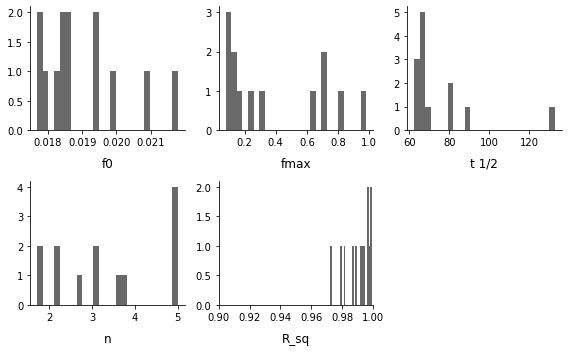

In [2]:
def calcRsq(dataX, dataY):
    '''Given 2 lists, this function calculates the R2'''
    x = np.array(dataX)
    y = np.array(dataY)
  
    x = x.reshape((-1, 1))
    model = LinearRegression()
    model.fit(x,y)
    
    rSq = model.score(x, y)
    yInt = model.intercept_
    m = model.coef_
    xInt = -yInt/m
    
    return rSq

def fitHill(y_exp, runID, i):
    x = list(np.linspace(0, 240, 61)) #time (min)
    
    #Set v max to the final value of the time course
    fmax = y_exp[-1]
   
    #Set v0 to the intiial value of the time course
    f0 = y_exp[0]

    
    #Define a function to calculate the residual between the input simulation value (sim) and the Hill fit (model)
    def residual(p, x, y_exp):
        km = p['km'].value
        #print('km: ' + str(km))
        n = p['n'].value
        #print('n: ' + str(n))
        model = (((fmax - f0) * (x ** n)) / (km ** n + x ** n)) + f0
        #print(model)
        #print('***')
        return (y_exp - model)
    
    #Define parameters to be fit, along with initial guesses
    p = Parameters()
    p.add('km', value=10e-2, min=0, vary = True)
    p.add('n', value=2, min=0, max = 5, vary = True)
    
    #Perform the fit
    out = minimize(residual, p, args=(x, y_exp))
    bestFitParams = out.params.valuesdict()
    bestFitParamsList= bestFitParams.values()
    
    #Define fit parameters
    fit = []
    for value in bestFitParamsList:
        fit.append(value)
    km = fit[0]
    n = fit[1]
    
    #Simulate the Hill fit
    y_Hill = []
    for item in x:
        value = (((fmax - f0) * (item ** n)) / (km ** n + item ** n)) + f0
        y_Hill.append(value)
    
    #Calculate the R2 between the data and the Hill fit
    R_sq = calcRsq(y_exp, y_Hill)
    
    if runID == 'plot' or i == 15:
        figure2 = plt.figure(figsize = (3,3))
        plt.plot(x, y_exp, color = 'black', marker='o', linestyle = 'None', fillstyle = 'none')
        plt.xlabel('Time (min)')
        plt.ylabel('Normalized readout')
        plt.plot(x, y_Hill, color = 'black',  linestyle = 'dashed')
        plt.legend(['Simulation', 'Hill fit'])
        plt.title('R2 = ' + str(np.round(R_sq, 3)))
        plt.savefig('Figure 3 representative Hill fit.svg', dpi = 600)
    
    return f0, fmax, km, n, R_sq

#Unnpack the data from "exp_data" and "error"
def chunks(lst, n):
        """Yield successive n-sized chunks from lst."""
        for i in range(0, len(lst), n):
            yield lst[i:i + n]
        
def fitHillAllData(data_lists, type_):
    fit_params = []
    i = 0
    for time_course in data_lists:
        f0, fmax, km, n, R_sq = fitHill(time_course, '', i)
        fit_params.append([f0, fmax, km, n, R_sq])
        i += 1

    df = pd.DataFrame()
    f0 = [list_[0] for list_ in fit_params]
    fmax = [list_[1] for list_ in fit_params]
    km = [list_[2] for list_ in fit_params]
    n = [list_[3] for list_ in fit_params]
    R_sq = [list_[4] for list_ in fit_params]

    df['f0'] = f0
    df['fmax'] = fmax
    df['km'] = km
    df['n'] = n
    df['R_sq'] = R_sq
    
    
    fig = plt.figure(figsize = (8,5))
    ax1 = plt.subplot(231)   
    ax2 = plt.subplot(232)
    ax3 = plt.subplot(233)
    ax4 = plt.subplot(234)
    ax5 = plt.subplot(235)
  

    color_ = 'dimgrey'
    
    #representative plot of exp data and Hill fit

    bins_ = 25
    ax1.hist(f0, bins=bins_, color = color_)
    ax1.set_xlabel('f0')
    #ax2.set_ylabel('count')

    ax2.hist(fmax, bins=bins_, color = color_)
    ax2.set_xlabel('fmax')
    #ax3.set_ylabel('count')

    ax3.hist(km, bins=bins_, color = color_)
    ax3.set_xlabel('t 1/2')
    #ax5.set_ylabel('count')

    ax4.hist(n, bins=bins_, color = color_)
    ax4.set_xlabel('n')
    #ax6.set_ylabel('count')

    ax5.hist(R_sq, bins=bins_, color = color_)
    ax5.set_xlabel('R_sq')
    #ax4.set_ylabel('count')
    ax5.set_xlim([0.90, 1.0])

    plt.savefig('Figure 3 histograms of summary metrics ' + type_ + '.svg', dpi = 600)
    
    return R_sq, fmax, km

error_lists = list(chunks(error, 61))
data_lists = list(chunks(exp_data, 61))
R_sq_list, fmax_list, t_half_list = fitHillAllData(data_lists, 'exp')

### Plot fmax vs t1/2 and color by enzyme value

In [3]:
def plot_tradeoff(x, fmax, t_half):
    fig, axes = plt.subplots(ncols=3,nrows=1, sharex=True, sharey=True, figsize = (9,3))
    
    for color_by, ax in zip(['T7', 'RT', 'RNAse'], axes.flat):
        
        if color_by == 'T7':
            vals = [1.0, 5.0, 20.0]
            colors = ['lightgreen', 'mediumseagreen', 'darkgreen']    
            varyIndex = 0
        elif color_by == 'RT':
            vals = [0.5, 2.5, 10.0]
            colors = ['lightsteelblue', 'royalblue', 'midnightblue']
            varyIndex = 1
        elif color_by == 'RNAse':
            vals = [0.001, 0.005, 0.02]
            colors = ['lightcoral', 'red', 'maroon']
            varyIndex = 2
            
        for i, enzyme_condition in enumerate(x):
            if enzyme_condition[varyIndex] == vals[0]:
                color_ = colors[0]
            elif enzyme_condition[varyIndex] == vals[1]:
                color_ = colors[1]
            elif enzyme_condition[varyIndex] == vals[2]:
                color_ = colors[2]     

            if enzyme_condition[3] == 1 and enzyme_condition[4] == 90:
                ax.plot(t_half[i], fmax[i],  marker = 'o', linestyle = 'None', color = color_)

            if enzyme_condition == [5.0, 2.5, 0.005, 1, 90]:
                ax.plot(t_half[i], fmax[i],  marker = 'o', linestyle = 'None', color = 'dimgrey')
            if enzyme_condition == [5.0, 10.0, 0.02, 1, 90]:
                ax.plot(t_half[i], fmax[i],  marker = 'o', linestyle = 'None', color = 'black')
            
            if color_by == 'RT':
                ax.set_xlabel('t 1/2 (min.)')
            if color_by == 'T7':
                ax.set_ylabel('f max (normalized)')
            ax.set_ylim([1,0])
            ax.set_xlim([60, 100])
        
    plt.savefig('./experimental performance metric tradeoff subplots.svg')


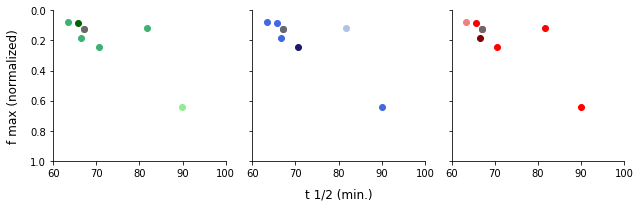

In [4]:
plot_tradeoff(x, fmax_list, t_half_list)

#### Figure 3e - Fmax box plots

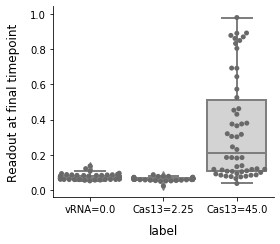

In [5]:
def plotFmaxBoxPlot(df, data_type):

    # Plot Fmax distributions (box plot) for different slices of the data
    background_only = []
    lowCas13_only = []
    highCas13_only = []

    if data_type == 'exp':
        maxVal = 0.6599948235700113
        for (columnName, columnData) in df.iteritems():
            label = list(columnData.iloc[0])

            if label[3] == 0.0:
                final_val = list(columnData.iloc[1:])[-1]/maxVal
                background_only.append(final_val)
            if label[4] == 90.0 and label[3] != 0.0:
                final_val = list(columnData.iloc[1:])[-1]/maxVal
                highCas13_only.append(final_val)
            if label[4] == 4.5 and label[3] != 0.0:
                final_val = list(columnData.iloc[1:])[-1]/maxVal
                lowCas13_only.append(final_val)
                
    elif data_type == 'sim':
        
         def Convert(string):
            li = string.strip("[]")

            li = list(li.split(", "))
            return li
        
         for (columnName, columnData) in df.iteritems():
            label = Convert(columnName)
            time = np.linspace(0, 240, 61)
          
            final_val = columnData[60]
            print(final_val)
            if label[4] == '90' and label[3] != '0.0':
                highCas13_only.append(final_val)
            if label[4] == '4.5' and label[3] != '0.0':
                lowCas13_only.append(final_val)

    df = pd.DataFrame()
    if data_type == 'exp':
        df['Readout at final timepoint'] = background_only + lowCas13_only + highCas13_only 
        df['label'] = ['vRNA=0.0'] * len(background_only) + ['Cas13=2.25'] * len(lowCas13_only) + ['Cas13=45.0'] * len(highCas13_only)
    
    elif data_type == 'sim':
        df['Readout at final timepoint'] = lowCas13_only + highCas13_only 
        df['label'] = ['Cas13=2.25'] * len(lowCas13_only) + ['Cas13=45.0'] * len(highCas13_only)


    fig = plt.figure(figsize = (4,3.5))
    sns.boxplot(x="label", y="Readout at final timepoint", data=df, color = 'lightgrey')
    sns.swarmplot(x="label", y="Readout at final timepoint", data=df, color = 'dimgrey')
    plt.savefig('./Figure 3e box plot of readout at final timepoint for different data sets ' + data_type + ' .svg')
    
#plotFmaxBoxPlot(df_sim, 'sim')
plotFmaxBoxPlot(df_data, 'exp')

#### Figure 3f, g, h and Figure 4f, g, h - experimental and simulated time courses 

In [6]:
def resultsPanel(dfSim, dfExp, dfErr, labels, varyCondition):    
    fig = plt.figure(figsize = (12,3))
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    ax1 = plt.subplot(141)   
    ax2 = plt.subplot(142)
    ax3 = plt.subplot(143)   
    ax4 = plt.subplot(144)
   
    def grabData(labels):
        count = 0
        sim = [1,1,1]
           
        for (columnName, columnData) in dfSim.iteritems():
            label = str(columnName)
    
            time = np.linspace(0, 240, 61)
            t_course = columnData
   
            if label == str(labels[0]):
                sim[0] = t_course
            elif label == str(labels[1]):
                sim[1] = t_course
            elif label == str(labels[2]):
                sim[2] = t_course
 
                
        maxVal = 0.6599948235700113
        exp = [1,1, 1]  
        for (columnName, columnData) in dfExp.iteritems():
            label = list(columnData.iloc[0])
            
            time = np.linspace(0, 240, 61)
            if label == labels[0]:
                t_course = columnData.iloc[1:]
                exp[0] = [i/maxVal for i in t_course]
            elif label == labels[1]:
                t_course = columnData.iloc[1:]
                exp[1] = [i/maxVal for i in t_course]
            elif label == labels[2]:
                t_course = columnData.iloc[1:]
                exp[2] = [i/maxVal for i in t_course]
                
        err = [1,1,1]  
        for (columnName, columnData) in dfErr.iteritems():
            label = list(columnData.iloc[0])
            
            time = np.linspace(0, 240, 61)
            if label == labels[0] and label != [5.0, 2.5, 0.001, 0, 90]:
                t_course = columnData.iloc[1:]
                err[0] = [i/maxVal for i in t_course]
            elif label == labels[1]:
                t_course = columnData.iloc[1:]
                err[1] = [i/maxVal for i in t_course]
            elif label == labels[2]:
                t_course = columnData.iloc[1:]
                err[2] = [i/maxVal for i in t_course]
            
                
        '''if varyCondition == 'RNAse' and labels[0][3] == 0: #don't have this data
            t_course = [0] * 61  
            sim[0] = t_course
            exp[0] = t_course
            err[0] = t_course'''
            
        # if varyCondition == 'T7' and labels[0][3] == 1.0: #don't have this data
        #     t_course = [0] * 61 
        #     sim[0] = t_course
        #     exp[0] = t_course
        #     err[0] = t_course
                
        return sim, exp, err

    sim1, exp1, err1 = grabData(labels)

    if varyCondition == 'T7':
        varyIndex = 0
        vals = [1.0, 5.0, 20.0]
        colors = ['lightgreen', 'mediumseagreen', 'darkgreen']    
    elif varyCondition == 'RT':
        varyIndex = 1
        vals = [0.5, 2.5, 10.0]
        colors = ['lightsteelblue', 'royalblue', 'midnightblue']
    elif varyCondition == 'RNAse':
        varyIndex = 2
        vals = [0.001, 0.005, 0.02]
        colors = ['lightcoral', 'red', 'maroon']
        
    time = np.linspace(0, 240, 61)
    '''for i in range(0, len(sim0)):
        ax4.plot(time, sim0[i], linestyle = ':', color = colors[i])
        ax4.set_xscale('linear')'''
    
   
    
    for i in range(0, len(exp1)):
        list_exp = exp1[i]
        list_err = err1[i]
        upper_y = []
        lower_y = []
        for j, val in enumerate(list_exp):
            upper_y.append(val + list_err[j])
            lower_y.append(val - list_err[j])

        ax1.fill_between(time, lower_y, upper_y, alpha = .2, color = colors[i])
        ax1.plot(time, exp1[i],  marker = None, linestyle = 'solid', color = colors[i])
        ax1.set_xscale('linear')
        
    for i in range(0, len(sim1)):
        ax3.plot(time, sim1[i],  marker = None, linestyle = 'dotted', color = colors[i])
    
    
    #ax1.legend([str(i) for i in vals], title = varyCondition, bbox_to_anchor=(1.0, .7))
    ax1.set_xlabel('Time (min)')
    ax1.set_ylabel('Normalized exp output')
    #ax4.set_xlabel('Time (min)')
    #ax4.set_ylabel('Normalized sim output')
    ax1.set_title('vRNA = 1fM', fontsize = 10, fontweight = 'bold')
    ax3.set_title('vRNA = 1fM', fontsize = 10, fontweight = 'bold')
    ax4.set_title('vRNA = 10fM', fontsize = 10, fontweight = 'bold')
    
   
    for i in range(0, len(labels)):
        labels[i][3] = 10
    
    sim10, exp10, err10 = grabData(labels)
    
    for i in range(0, len(sim1)):
        if varyCondition == 'RT' and i == 0: #condition dropped due to high error
            continue
        else:
            ax4.plot(time, sim10[i],  marker = None, linestyle = 'dotted', color = colors[i])
        
    '''for i in range(0, len(sim1)):
        ax5.plot(time, sim1[i], linestyle = ':', color = colors[i])
        ax5.set_xscale('linear')'''
        
    for i in range(0, len(exp10)):
        list_exp = exp10[i]
        list_err = err10[i]
        upper_y = []
        lower_y = []
        for j, val in enumerate(list_exp):
            upper_y.append(val + list_err[j])
            lower_y.append(val - list_err[j])

        ax2.fill_between(time, lower_y, upper_y, alpha = .2, color = colors[i])
        ax2.plot(time, exp10[i],  marker = None, linestyle = 'solid', color = colors[i])
        ax2.set_xscale('linear')
    
    ax2.set_xlabel('Time (min)')
    #ax2.set_ylabel('Normalized exp output')
    #ax5.set_xlabel('Time (min)')
    #ax5.set_ylabel('Normalized sim output')
    ax2.set_title('vRNA = 10fM', fontsize = 10, fontweight = 'bold')
    ax2.legend([str(i) for i in vals], title = varyCondition, bbox_to_anchor=(1.0, .7))
    ax4.legend([str(i) for i in vals], title = varyCondition, bbox_to_anchor=(1.0, .7))
    plt.savefig('./Figure 3fgh selected time courses colored by ' + varyCondition + '.svg', dpi = 600, bbox_inches="tight")

def plotSlice(df_sim):
    cas =  90
    labels = [[1.0, 2.5, 0.005, 1,cas], [5.0, 2.5, 0.005, 1, cas], [20.0, 2.5, 0.005, 1, cas]]
    varyCondition = 'T7'
    resultsPanel(df_sim, df_data, df_error, labels, varyCondition) 
    print('T7 done')

    labels = [[5.0, 0.5, 0.005, 1, cas], [5.0, 2.5, 0.005, 1, cas], [5.0, 10.0, 0.005, 1, cas]]
    varyCondition = 'RT'
    resultsPanel(df_sim, df_data, df_error, labels, varyCondition) 
    print('RT done')
    
    labels = [[5.0, 2.5, 0.001, 1, cas], [5.0, 2.5, 0.005,1, cas], [5.0, 2.5, 0.02, 1, cas]]
    varyCondition = 'RNAse'
    resultsPanel(df_sim, df_data, df_error, labels, varyCondition) 
    print('RNAse done')

p = [3.2708473275180174e-05, 2677.071809398809, 2256.0052576508065, 0.2960119850108069, 20702.650674976157, 52.36016435572264, 7.17766539510405, 62.5023586929695, 10.645921202330825]  
x, norm_solutions, mse, df_sim = solveAll(p, exp_data)


Failed filter 2
ratio2: The max lowiCas13/max high iCas13 ratio is: 0.1032663913619688


### data = 'slice drop high error'

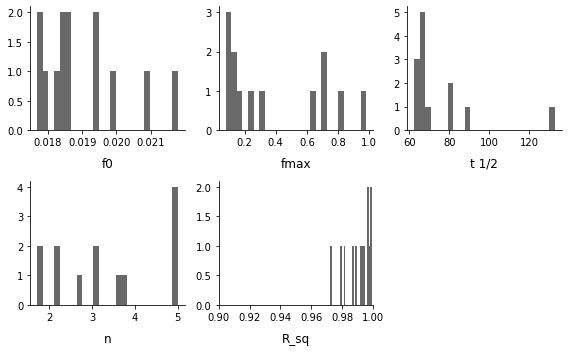

In [7]:
def calcRsq(dataX, dataY):
    '''Given 2 lists, this function calculates the R2'''
    x = np.array(dataX)
    y = np.array(dataY)
  
    x = x.reshape((-1, 1))
    model = LinearRegression()
    model.fit(x,y)
    
    rSq = model.score(x, y)
    yInt = model.intercept_
    m = model.coef_
    xInt = -yInt/m
    
    return rSq

def fitHill(y_exp, runID, i):
    x = list(np.linspace(0, 240, 61)) #time (min)
    
    #Set v max to the final value of the time course
    fmax = y_exp[-1]
   
    #Set v0 to the intiial value of the time course
    f0 = y_exp[0]

    
    #Define a function to calculate the residual between the input simulation value (sim) and the Hill fit (model)
    def residual(p, x, y_exp):
        km = p['km'].value
        #print('km: ' + str(km))
        n = p['n'].value
        #print('n: ' + str(n))
        model = (((fmax - f0) * (x ** n)) / (km ** n + x ** n)) + f0
        #print(model)
        #print('***')
        return (y_exp - model)
    
    #Define parameters to be fit, along with initial guesses
    p = Parameters()
    p.add('km', value=10e-2, min=0, vary = True)
    p.add('n', value=2, min=0, max = 5, vary = True)
    
    #Perform the fit
    out = minimize(residual, p, args=(x, y_exp))
    bestFitParams = out.params.valuesdict()
    bestFitParamsList= bestFitParams.values()
    
    #Define fit parameters
    fit = []
    for value in bestFitParamsList:
        fit.append(value)
    km = fit[0]
    n = fit[1]
    
    #Simulate the Hill fit
    y_Hill = []
    for item in x:
        value = (((fmax - f0) * (item ** n)) / (km ** n + item ** n)) + f0
        y_Hill.append(value)
    
    #Calculate the R2 between the data and the Hill fit
    R_sq = calcRsq(y_exp, y_Hill)
    
    if runID == 'plot' or i == 15:
        figure2 = plt.figure(figsize = (3,3))
        plt.plot(x, y_exp, color = 'black', marker='o', linestyle = 'None', fillstyle = 'none')
        plt.xlabel('Time (min)')
        plt.ylabel('Normalized readout')
        plt.plot(x, y_Hill, color = 'black',  linestyle = 'dashed')
        plt.legend(['Simulation', 'Hill fit'])
        plt.title('R2 = ' + str(np.round(R_sq, 3)))
        plt.savefig('Figure 3 representative Hill fit.svg', dpi = 600)
    
    return f0, fmax, km, n, R_sq

#Unnpack the data from "exp_data" and "error"
def chunks(lst, n):
        """Yield successive n-sized chunks from lst."""
        for i in range(0, len(lst), n):
            yield lst[i:i + n]
        
def fitHillAllData(data_lists, type_):
    fit_params = []
    i = 0
    for time_course in data_lists:
        f0, fmax, km, n, R_sq = fitHill(time_course, '', i)
        fit_params.append([f0, fmax, km, n, R_sq])
        i += 1

    df = pd.DataFrame()
    f0 = [list_[0] for list_ in fit_params]
    fmax = [list_[1] for list_ in fit_params]
    km = [list_[2] for list_ in fit_params]
    n = [list_[3] for list_ in fit_params]
    R_sq = [list_[4] for list_ in fit_params]

    df['f0'] = f0
    df['fmax'] = fmax
    df['km'] = km
    df['n'] = n
    df['R_sq'] = R_sq
    
    filename = 'experimental summary metrics'
    with pd.ExcelWriter(filename + '.xlsx') as writer:  
        df.to_excel(writer, sheet_name='')
    
    
    fig = plt.figure(figsize = (8,5))
    ax1 = plt.subplot(231)   
    ax2 = plt.subplot(232)
    ax3 = plt.subplot(233)
    ax4 = plt.subplot(234)
    ax5 = plt.subplot(235)
  

    color_ = 'dimgrey'
    
    #representative plot of exp data and Hill fit

    bins_ = 25
    ax1.hist(f0, bins=bins_, color = color_)
    ax1.set_xlabel('f0')
    #ax2.set_ylabel('count')

    ax2.hist(fmax, bins=bins_, color = color_)
    ax2.set_xlabel('fmax')
    #ax3.set_ylabel('count')

    ax3.hist(km, bins=bins_, color = color_)
    ax3.set_xlabel('t 1/2')
    #ax5.set_ylabel('count')

    ax4.hist(n, bins=bins_, color = color_)
    ax4.set_xlabel('n')
    #ax6.set_ylabel('count')

    ax5.hist(R_sq, bins=bins_, color = color_)
    ax5.set_xlabel('R_sq')
    #ax4.set_ylabel('count')
    ax5.set_xlim([0.90, 1.0])

    plt.savefig('Figure 3 histograms of summary metrics ' + type_ + '.svg', dpi = 600)
    
    return R_sq, fmax

error_lists = list(chunks(error, 61))
data_lists = list(chunks(exp_data, 61))
R_sq_list, fmax_list = fitHillAllData(data_lists, 'exp')